# KAIST AI605 Assignment 1: Text Classification with RNNs
Authors: Hyeong-Gwon Hong (honggudrnjs@kaist.ac.kr) and Minjoon Seo (minjoon@kaist.ac.kr)

**Due Date:** March 31 (Wed) 11:00pm, 2021

## Assignment Objectives
- Verify theoretically and empirically why gating mechanism (LSTM, GRU) helps in Recurrent Neural Networks (RNNs)
- Design an LSTM-based text classification model from scratch using PyTorch.
- Apply the classification model to a popular classification task, Stanford Sentiment Treebank v2 (SST-2).
- Achieve higher accuracy by applying common machine learning strategies, including Dropout.
- Utilize pretrained word embedding (e.g. GloVe) to leverage self-supervision over a large text corpus.
- (Bonus) Use Hugging Face library (`transformers`) to leverage self-supervision via large language models.

## Your Submission
Your submission will be a link to a Colab notebook that has all written answers and is fully executable. You will submit your assignment via KLMS. Use in-line LaTeX (see below) for mathematical expressions. Collaboration among students is allowed but it is not a group assignment so make sure your answer and code are your own. Make sure to mention your collaborators in your assignment with their names and their student ids.

## Grading
The entire assignment is out of 100 points. There are four bonus questions with 10 points each (two bonus questions added on Mar 19). Your final score can be higher than 100 points.


## Environment
You will only use Python 3.7 and PyTorch 1.8, which is already available on Colab:

In [ ]:
from platform import python_version
import torch

print("python", python_version())
print("torch", torch.__version__)

python 3.7.10
torch 1.8.1+cu101


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available()else "cpu"); device

device(type='cuda', index=0)

In [ ]:
from collections import Counter
from itertools import repeat
from tqdm import tqdm
import operator

import os
import numpy as np
import pandas as pd
import copy
import math
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

## 1. Limitations of Vanilla RNNs
In Lecture 04 and 05, we saw how RNNs suffer from exploding or vanishing gradients. We mathematically showed that, if the recurrent relation is
$$ \textbf{h}_t = \sigma (\textbf{V}\textbf{h}_{t-1} + \textbf{U}\textbf{x}_t + \textbf{b}) $$
then
$$ \frac{\partial \textbf{h}_t}{\partial \textbf{h}_{t-1}} = \text{diag}(\sigma' (\textbf{V}\textbf{h}_{t-1} + \textbf{U}\textbf{x}_t + \textbf{b}))\textbf{V}$$
so
$$\frac{\partial \textbf{h}_T}{\partial \textbf{h}_1} \propto \textbf{V}^{T-1}$$
which means this term will be very close to zero if the norm of $\bf{V}$ is smaller than 1 and really big otherwise.

**Problem 1.1** *(10 points)* Explain how exploding gradient can be mitigated if we use gradient clipping.

---

**Answer** : The gradient clipping is performed in this way:

$\frac{\partial \epsilon}{\partial \theta} = \frac{threshold}{||\hat{g}||}\hat{g}$ if $ ||\hat{g}||\geq $ threshold,   $\hat{g}$ otherwise.


If the L2-Norm value of the gradient at specific layer is larger than the threshold I decided, by normalizing the gradient by L2-Norm value, the gradient values are resized to the values between 0 and 1. It means that, though V matrices are continously multiplied, the value would not exceed 1. After the gradient clipping, any value would be smaller than 1. Considering that the product of the values smaller than 1 is always smaller than 1, exploding gradient problem might be solved. 

---
---

**Problem 1.2** *(10 points)* Explain how vanishing gradient can be mitigated if we use LSTM. See the Lecture 04 and 05 slides for the definition of LSTM.

---

**Answer** : Personally, I think, the main contribution of LSTM at mitigating the vanishing gradient problem is introduction of `cell state` $c_t$. Cell state passes a LSTM module without matrix multiplication with weight matrix, so there's much less possibility of gradient-vanishing probelm to happen. However, as the number of layers deepens, gradient vanishing problem still happens in LSTM, likewise.   

Writing in equation, it is more obvious

$f_t = \sigma_g(W_fx_t + U_f h_{t-1} + b_f)$

$i_t = \sigma_g(W_ix_t + U_i h_{t-1} + b_i)$

$o_t = \sigma_g(W_ox_t + U_o h_{t-1} + b_o)$

$\tilde{c}_t = \sigma_c(W_cx_t + U_c h_{t-1} + b_c)$

$c_t = f_t \cdot c_{t-1} + i_t \cdot \tilde{c}_t$

$h_t = o_t \cdot \sigma_h (c_t)$

As the equation says, the highway c does not get matrix multiplication. So, the possibility of gradient related problem to happen would decrease. 

## 2. Creating Vocabulary from Training Data
Creating the vocabulary is the first step for every natural language processing model. In this section, you will use Stanford Sentiment Treebank v2, a popular dataset for sentiment classification, to create your vocabulary.

### Obtaining SST-2 via GLUE
General Language Understanding Evaluation (GLUE) benchmark is a collection of tools for evaluating the performance of models across a diverse set of existing natural language understanding (NLU) tasks. See GLUE website (https://gluebenchmark.com/) and the GLUE paper (https://openreview.net/pdf?id=rJ4km2R5t7) for more details. GLUE provides an easy way to access the datasets, including SST-2.
You can download SST-2 dataset by following the steps below:

1. Clone GitHub repository:

In [ ]:
!git clone https://github.com/nyu-mll/GLUE-baselines.git

Cloning into 'GLUE-baselines'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 891 (delta 1), reused 2 (delta 0), pack-reused 886
Receiving objects: 100% (891/891), 1.48 MiB | 21.01 MiB/s, done.
Resolving deltas: 100% (610/610), done.


2. Download SST-2 only:

In [ ]:
%cd GLUE-baselines/
!python download_glue_data.py --data_dir glue_data --tasks SST

/content/GLUE-baselines
	Completed!


Your training, dev, and test data can be found at `glue_data/SST-2`. Note that each file is in a tsv format, where the first column is the sentence and the second column is the label (either 0 or 1, where 1 means positive sentiment). 

In [ ]:
!head -10 glue_data/SST-2/train.tsv

sentence	label
hide new secretions from the parental units 	0
contains no wit , only labored gags 	0
that loves its characters and communicates something rather beautiful about human nature 	1
remains utterly satisfied to remain the same throughout 	0
on the worst revenge-of-the-nerds clichés the filmmakers could dredge up 	0
that 's far too tragic to merit such superficial treatment 	0
demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . 	1
of saucy 	1
a depressed fifteen-year-old 's suicidal poetry 	0


**Problem 2.1** *(10 points)* Using space tokenizer, create the vocabulary for the training data and report the vocabulary size here. Make sure that you add an `UNK` token to the vocabulary to account for words (during inference time) that you haven't seen. See below for an example with a short text.

---

**Answer** I didn't exclude punchuations or blanks, such as ' ' and ?, because there was no instructions to exclude those things at the example code. Not deleting it, the total number of vocabulary sizes including `UNK` are 14818.

In [ ]:
# Space tokenization
text = "Hello world!"
tokens = text.split(' ')
print(tokens)

['Hello', 'world!']


In [ ]:
# Constructing vocabulary with `UNK`
vocab = ['UNK'] + list(set(text.split(' ')))
word2id = {word: id_ for id_, word in enumerate(vocab)}
print(vocab)
print(word2id['Hello'])

['UNK', 'world!', 'Hello']
2


In [ ]:
!pwd

/content/GLUE-baselines


In [ ]:
current_path = os.getcwd()
train_path = os.path.join(current_path, 'glue_data/SST-2/train.tsv')

train_words = list()
train_words_with_duplication = None

train_data = pd.read_csv(train_path, sep='\t')
train_sentence = train_data['sentence']

for i in range(len(train_sentence)):
  temp = train_sentence[i].split(' ')
  train_words.extend(temp)

  if i == (len(train_sentence)-1):
    train_words_with_duplication = copy.deepcopy(train_words)
    train_words = list(set(train_words))
    # train_words.remove('')
    train_words.append('UNK') 

print('The vocabulary for training data: \n{}'.format(train_words))
print('The vocabulary size: {}'.format(len(train_words)))

The vocabulary for training data: 
['', 'strenuous', 'sanctimony', 'pushed', 'deceptively', 'putters', 'saga', 'enjoying', 'fantasies', 'singles', 'hampered', 'bizarre', 'fitfully', 'misuse', 'steps', 'masala', 'silver', 'etched', 'drama/action', 'demonstrates', '3', 'pulp', 'creeping', 'pictures', 'scooby', 'throws', 'bucket', 'atop', 'exotic', 'tangents', 'not-too-distant', 'hostile', 'accumulates', 'open-ended', 'performers', 'late-summer', 'liked', 'mildly', 'ailments', 'fincher', 'during', 'black-and-white', 'delving', 'instance', 'sewer', 'calculating', 'bueller', 'gobbler', 'monologues', 'previous', 'a', 'foolish', 'futuristic', 'tendencies', 'catch', 'careening', 'courtship', 'tasteless', 'garbled', 'wisdom', 'obscenely', 'violent', 'indoor', 'destined', 'strong-minded', 'strategic', 'chung', 'no.', 'hughes', 'drains', 'swords', 'pop-cyber', 'fluttering', 'balancing', 'denouement', 'satisfying', 'cash', 'year-end', 'suspenseful', 'finely', 'preferable', 'libretto', 'bar', 'bomb

**Problem 2.2** *(10 points)* Using all words in the training data will make the vocabulary very big. Reduce its size by only including words that occur at least 2 times. How does the size of the vocabulary change?

---

**Answer** From 14818 as stated above, when I exclude the words which appear less than 2 times, the size reduces to 14310. Of course, I didn't exclude the punctations or blanks because it is not demanded on the example code.

In [ ]:
word_counts = Counter(train_words_with_duplication)
word_for_2times = []

for (key, value) in word_counts.items():
  if key == 'UNK':
      continue
  elif value >= 2:
    word_for_2times.append(key)

# For later usage {word: id} dictionary
word2id_train = {word: id_ for id_, word in enumerate(word_for_2times)}

print(len(word_for_2times))
print(word_for_2times)

14310
['hide', 'new', 'secretions', 'from', 'the', 'parental', 'units', '', 'contains', 'no', 'wit', ',', 'only', 'labored', 'gags', 'that', 'loves', 'its', 'characters', 'and', 'communicates', 'something', 'rather', 'beautiful', 'about', 'human', 'nature', 'remains', 'utterly', 'satisfied', 'to', 'remain', 'same', 'throughout', 'on', 'worst', 'revenge-of-the-nerds', 'clichés', 'filmmakers', 'could', 'dredge', 'up', "'s", 'far', 'too', 'tragic', 'merit', 'such', 'superficial', 'treatment', 'demonstrates', 'director', 'of', 'hollywood', 'blockbusters', 'as', 'patriot', 'games', 'can', 'still', 'turn', 'out', 'a', 'small', 'personal', 'film', 'with', 'an', 'emotional', 'wallop', '.', 'saucy', 'depressed', 'fifteen-year-old', 'suicidal', 'poetry', 'are', 'more', 'deeply', 'thought', 'through', 'than', 'in', 'most', '`', 'right-thinking', "'", 'films', 'goes', 'absurd', 'lengths', 'for', 'those', 'moviegoers', 'who', 'complain', 'they', 'do', "n't", 'make', 'movies', 'like', 'used', 'anymo

Explanation about 'train_data_final_data':

- I read the raw data with the filename, 'train_data.' 
- However, problem claimed not to consider the words with frequency less than 2. 
- So, before embedding, I replaced all the less-frequent words with 'Less_than_2' to clearly identify them. 

In [ ]:
# train_final_data: for 'Baseline' model

word_less_than_2times = list(set(train_words) - set(word_for_2times))
word_less_than_2times.remove('UNK')

train_final_data = copy.deepcopy(train_data)

# Replace the words that appear less than 2 times with 'Less_than_2'. 
for i in tqdm(range(len(train_final_data))):
  temp = train_final_data.loc[i, 'sentence'].split(' ')
  word_length = len(temp)
  for j in range(word_length):
    if temp[j] in word_less_than_2times:
      temp[j] = 'Less_than_2'
  temp_concat = ' '.join(temp)
  train_final_data.loc[i, 'sentence'] = temp_concat

word_for_2times.append('Less_than_2') 
word_for_2times.append('UNK')
word2id_train['Less_than_2'] = [*word2id_train.values()][-1]+1
word2id_train['UNK'] = [*word2id_train.values()][-1]+1

train_final_data

100%|██████████| 67349/67349 [02:16<00:00, 493.91it/s]


,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...
67344,a delightful comedy,1
67345,"anguish , anger and frustration",0
67346,"at achieving the modest , crowd-pleasing goals...",1
67347,a patient viewer,1


## 3. Text Classification Baselines

You can now use the vocabulary constructed from the training data to create an embedding matrix. You will use the embedding matrix to map each input sequence of tokens to a list of embedding vectors. One of the simplest baseline is to go through one layer of neural network and then average the outputs, and finally classify the average embedding: 

### Code for Baselines (Given)

In [ ]:
input_ = "hi world!"
input_tokens = input_.split(' ')
input_ids = [word2id[word] if word in word2id else 0 for word in input_tokens]
input_tensor = torch.LongTensor([input_ids]) # the first dimension is minibatch size
print(input_tensor)

tensor([[0, 1]])


**A little bit modification on original code**

On the code below, 'Baseline', I changed `vocab` to `train_words` because I tried not to use the object name that professor previoiusly used, not to be confused :) Of course I could make that part as an argument of class, but I didn't do it not to edit too much from original code. 

In [ ]:
# One layer, average pooling and classification
class Baseline(nn.Module):
  def __init__(self, d):
    super(Baseline, self).__init__()
    self.embedding = nn.Embedding(len(word_for_2times), d) # I changed 'vocab' to 'train_words' 
    self.layer = nn.Linear(d, d, bias=True)
    self.relu = nn.ReLU()
    self.class_layer = nn.Linear(d, 2, bias=True)

  def forward(self, input_tensor):
    emb = self.embedding(input_tensor)
    out = self.relu(self.layer(emb))
    avg = out.mean(1)
    logits = self.class_layer(avg)
    return logits

d = 3 # usually bigger, e.g. 128
baseline = Baseline(d)
logits = baseline(input_tensor)
softmax = nn.Softmax(1)
print(softmax(logits)) # probability for each class

tensor([[0.5565, 0.4435]], grad_fn=<SoftmaxBackward>)


Now we will compute the loss, which is the negative log probability of the input text's label being the target label (`1`), which in fact turns out to be equivalent to the cross entropy (https://en.wikipedia.org/wiki/Cross_entropy) between the probability distribution and a one-hot distribution of the target label (note that we use `logits` instead of `softmax(logits)` as the input to the cross entropy, which allow us to avoid numerical instability). 

In [ ]:
cel = nn.CrossEntropyLoss()
label = torch.LongTensor([1]) # The ground truth label for "hi world!" is positive.
loss = cel(logits, label) # Loss, a.k.a L
print(loss)

tensor(0.8131, grad_fn=<NllLossBackward>)


Once we have the loss defined, only one step remains! We compute the gradients of parameters with respective to the loss and update. Fortunately, PyTorch does this for us in a very convenient way. Note that we used only one example to update the model, which is basically a Stochastic Gradient Descent (SGD) with minibatch size of 1. A recommended minibatch size in this exercise is at least 16. It is also recommended that you reuse your training data at least 10 times (i.e. 10 *epochs*).

In [ ]:
# Here is the code introduction part from professor. 
# Don't need to care about this section.

# optimizer = torch.optim.SGD(baseline.parameters(), lr=0.1)
# optimizer.zero_grad() # reset process
# loss.backward() # compute gradients
# optimizer.step() # update parameters

### **Code for minibatch problem**

`Problems 3.1~3.4 are in here`

- d = 128
- epochs = 10
- minibatch size = 16

In [ ]:
global_embedding = None

def minibatch_dataloader(data, n_mini, batch_idx, model, model_name):
  """
  data: data to process
  n_mini: size of minibatches
  batch_idx: index of minibatch being iterated
  model: the model declared from outside
  model_name: 'baseline' or 'rnn'
  """
  # Didn't use external library such as nltk deliberately. 
  minibatch_X = data.loc[batch_idx * n_mini:(batch_idx+1)*n_mini-1,'sentence'].str.split(' ') 
  minibatch_y = data.loc[batch_idx * n_mini:(batch_idx+1)*n_mini-1,'label']
  
  output_tensor = torch.zeros(n_mini, 2).to(device)
  minibatch_y = torch.from_numpy(minibatch_y.to_numpy()).to(device)

  if model_name == 'rnn':
    cutoff = sentence_length[batch_idx * n_mini:(batch_idx+1)*n_mini-1]
    minibatch_list = []

  for i in range(n_mini):
    
    mapping_list = minibatch_X.to_list()[i]
    
    if model_name == 'baseline':
      input_ids = [word2id_train[word] if word in word2id_train else 0 for word in mapping_list]
      input_tensor = torch.LongTensor([input_ids]).to(device)
      output_tensor[i,:] = model(input_tensor)

    elif model_name == 'rnn':
      embedding_list = model.embedding
      embedding_index = list(map(lambda x: word2id_train[x], mapping_list))
      mini_el = embedding_list(torch.LongTensor([embedding_index]).to(device))
      minibatch_list.append(mini_el)

      if i == n_mini-1:
        minibatch = torch.stack(minibatch_list, dim=1)
        cutoff = max(sentence_length[batch_idx*n_mini:(batch_idx+1)*n_mini-1])
        output_tensor = model(minibatch, cutoff)
      
        global_embedding = model.embedding # to use at test time

        return output_tensor, minibatch_y, global_embedding  

  return output_tensor, minibatch_y

In [ ]:
num_minibatch = 16
num_batch = math.floor(len(train_final_data)/num_minibatch) # Abandoned the leftover

baseline = Baseline(128).to(device) # As mentioned once from above
optimizer = torch.optim.SGD(baseline.parameters(), lr=0.1)

train_accuracy = []

for epoch in range(10):
  print('Present Epoch: {}'.format(str(epoch+1) + '/' + str(10) + ': '))
  correct = 0

  for batch_idx in tqdm(range(num_batch)): 
    logit, y_train = minibatch_dataloader(train_final_data, num_minibatch, batch_idx, baseline, 'baseline')

    loss = cel(logit, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred = logit.argmax(dim=-1)
    correct += (y_pred == y_train).sum().item()
    
  train_accuracy.append(correct / len(train_data))
  print('Training Accuracy: {}'.format(train_accuracy[-1]))

baseline.to('cpu')

  0%|          | 1/4209 [00:00<08:50,  7.93it/s]

Present Epoch: 1/10: 


  0%|          | 11/4209 [00:00<00:39, 107.49it/s]

Training Accuracy: 0.7022672942434186
Present Epoch: 2/10: 


  0%|          | 11/4209 [00:00<00:38, 107.87it/s]

Training Accuracy: 0.7997297658465604
Present Epoch: 3/10: 


  0%|          | 11/4209 [00:00<00:39, 106.73it/s]

Training Accuracy: 0.8328260256277005
Present Epoch: 4/10: 


  0%|          | 11/4209 [00:00<00:39, 107.22it/s]

Training Accuracy: 0.8513563675778408
Present Epoch: 5/10: 


  0%|          | 11/4209 [00:00<00:39, 106.97it/s]

Training Accuracy: 0.8648383791890005
Present Epoch: 6/10: 


  0%|          | 12/4209 [00:00<00:37, 112.55it/s]

Training Accuracy: 0.8743708147114285
Present Epoch: 7/10: 


  0%|          | 11/4209 [00:00<00:38, 107.89it/s]

Training Accuracy: 0.8815721094596801
Present Epoch: 8/10: 


  0%|          | 11/4209 [00:00<00:39, 106.26it/s]

Training Accuracy: 0.8879270664746322
Present Epoch: 9/10: 


  0%|          | 12/4209 [00:00<00:37, 112.35it/s]

Training Accuracy: 0.8924111716580796
Present Epoch: 10/10: 


100%|██████████| 4209/4209 [00:39<00:00, 107.64it/s]


Training Accuracy: 0.8967467965374393


Baseline(
  (embedding): Embedding(14312, 128)
  (layer): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (class_layer): Linear(in_features=128, out_features=2, bias=True)
)

Text(0.5, 1.0, 'Training Accuracy')

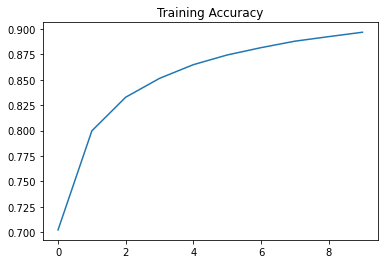

In [ ]:
plt.plot(train_accuracy)
plt.title('Training Accuracy')

Once you have done this, all weight parameters will have `grad` attributes that contain their gradients with respect to the loss.

In [ ]:
print(baseline.layer.weight.grad) # dL/dw of weights in the linear layer

tensor([[-0.0304, -0.0199,  0.0073,  ..., -0.0137,  0.0085,  0.0374],
        [ 0.0337, -0.0003, -0.0062,  ...,  0.0168, -0.0016, -0.0233],
        [ 0.0132, -0.0142,  0.0330,  ...,  0.0118,  0.0114,  0.0186],
        ...,
        [ 0.0456, -0.0061,  0.0365,  ...,  0.0164,  0.0020, -0.0294],
        [ 0.0036, -0.0235,  0.0115,  ...,  0.0016,  0.0013,  0.0118],
        [ 0.0134,  0.0091, -0.0083,  ...,  0.0048, -0.0212, -0.0018]])


**Problem 3.1** *(10 points)* Properly train this average-pooling baseline model on SST-2 and report the model's accuracy on the dev data.

---  
**Answer**
At first, I trained the one layer, really simple model using training data. Its performance kept increased, but stuck below accuracy of 90%. Anyway, when I tested on dev set for the assessment of performance, I got accuracy value between 70 and 75%. For the last trial, I got about 73% accuracy. Performed worse than on the training set. (It's natural a result.)

---

**Problem 3.2** *(10 points)* Implement a recurrent neural network (without using PyTorch's RNN module) where the output of the linear layer not only depends on the current input but also the previous output. Report the model's accuracy on the dev data. Is it better or worse than the baseline? Why?

---

**Answer** RNN was definitely better. On baseline model, accuracy against dev set was about 73%. However, in case of RNN, accuracy was about 78%. And, in convenience, I just padded a sentence per minibatch. For example, let's suppose I took the minibatch with size 100. I take the length of the longest sentence's token size among a minibatch as standard point to pad. If I have the sentence with the number of tokens being 10, and if the longest sentence in minibatch has length 30 tokens, I padded 20 tokens. At the training stage of RNN, I restrained the maximum length by minibatch unit. However, on the test time, the standard point was 53 which is the longest token size among whole batch. So the number of meaningless <Padding> token in training set was much less than that of test time's. Though, there was a penalty at the test time, neverthless, the accuracy of dev set was definitely better that that of baseline. 

---  

**Problem 3.3 (bonus)** *(10 points)* Show that the cross entropy computed above is equivalent to the negative log likelihood of the probability distribution.

---
**Answer**
The format of cross entropy is $\sum_i p_i log_2 \frac{1}{q_i}$ = $-\sum_i p_i log_2 q_i$. For the binary classification case, cross entropy can be represented as like this: $-y log \hat{y} - (1-y)log(1-\hat{y})$, where $\hat{y}$ is probability to predict as label1.

Anyway, likelihood can be represented as like this: $\hat{y}^y (1-\hat{y}^{1-y}
).$ If I take the log, the log likelihood is $ylog \hat{y} + (1-y)log(1-\hat{y})$. If I take minus as the 'negative loglikelihood' means, it can be expressed as $-ylog\hat{y} - (1-y)log(1-\hat{y})$. Amazingly, they are exactly same. 

---  

**Problem 3.4 (bonus)** *(10 points)* Why is it numerically unstable if you compute log on top of softmax?

---

**Answer** If I take softmax, then all the elements in a vector might have values between 0 and 1. In log function, when domain is between 0 and 1, the codomain value lies between negative infinity and 0. It is undesirable to have values toward infinity for learning. It is better to use built-in pytorch function `F.log_softmax` function at once, instead of applying log after the softmax in sequence.

---  

### **Code for Problem 3.1**

In [ ]:
def UNK_or_Less_than_2_check(interest):
  """
  interest: data being scrutinized
  """
  index = 0

  for word in interest:
    if word not in word2id_train.keys():
      interest[index] = 'UNK'
    elif word in word_less_than_2times:
      interest[index] = 'Less_than_2'

    index += 1

  return interest

In [ ]:
dev_path = os.path.join(current_path, 'glue_data/SST-2/dev.tsv')
dev_data = pd.read_csv(dev_path, sep='\t')

dev_sentence = dev_data.loc[:, 'sentence'].str.split(' ')
dev_label = dev_data.loc[:, 'label']
dev_nrow = len(dev_data)

coincide = []

with torch.no_grad():
  for i in range(dev_nrow):
    temp = dev_sentence[i]
    temp = UNK_or_Less_than_2_check(temp)

    input_ids = [word2id_train[word] if word in word2id_train else 0 for word in temp]
    input_tensor = torch.LongTensor([input_ids])

    pred = baseline(input_tensor).argmax(-1)
    coincide.append(pred == dev_label[i])

accuracy = sum(coincide).item() / dev_nrow
print('Dev set Accuracy: {}'.format(accuracy))

Dev set Accuracy: 0.7373853211009175


### **Code for Problem 3.2**

In [ ]:
sentence_length = list(map(lambda x: len(x), train_final_data.loc[:,'sentence'].str.split(' ')))
sentence_maximum_length = max(sentence_length)
seq_padding_length = list(map(operator.sub,
                              list(repeat(sentence_maximum_length, len(sentence_length))), 
                              sentence_length))

for i in tqdm(range(len(train_final_data))):
  temp = train_final_data.loc[i, 'sentence'].split(' ')
  temp.append('<Padding> '*seq_padding_length[i])
  temp_concat = ' '.join(temp)[:-1]  # to exclude ' ' made at the very last. 
  train_final_data.loc[i, 'sentence'] = temp_concat

word_for_2times.append('<Padding>')
word2id_train['<Padding>'] = [*word2id_train.values()][-1]+1

train_final_data

100%|██████████| 67349/67349 [02:07<00:00, 526.20it/s]


,sentence,label
0,hide new secretions from the parental units <...,0
1,"contains no wit , only labored gags <Padding>...",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...
67344,a delightful comedy <Padding> <Padding> <Padd...,1
67345,"anguish , anger and frustration <Padding> <Pa...",0
67346,"at achieving the modest , crowd-pleasing goals...",1
67347,a patient viewer <Padding> <Padding> <Padding...,1


In [ ]:
for i in range(dev_nrow):
  temp = dev_sentence[i]
  temp = UNK_or_Less_than_2_check(temp)
  temp = ' '.join(temp)
  dev_data.loc[i, 'sentence'] = temp

dev_data

,sentence,label
0,it 's a charming and often affecting journey .,1
1,UNK bleak and desperate,0
2,allows us to hope that nolan is UNK to UNK a m...,1
3,"the acting , costumes , music , cinematography...",1
4,"it 's slow -- very , very slow .",0
...,...,...
867,has all the depth of a UNK pool .,0
868,a movie with a real UNK flair .,1
869,a subject like this should inspire reaction in...,0
870,... is an UNK attempt at directing by UNK UNK .,0


In [ ]:
class RNNCell(nn.Module):
  # def __init__(self, input_dim, hidden_dim, output_dim=2):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(RNNCell, self).__init__()

    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim 

    self.weight_ih = nn.Linear(input_dim, hidden_dim)
    self.weight_hh = nn.Linear(hidden_dim, hidden_dim)
    # self.output = nn.Linear(hidden_dim, output_dim)

  # def forward(self, x, previous_hidden, last_layer=False): 
  def forward(self, x, previous_hidden):

    input_cal = self.weight_ih(x)
    hidden_cal = self.weight_hh(previous_hidden)
    hidden_state = torch.tanh(input_cal + hidden_cal)
   
    return hidden_state

    ################################################################################
    # My first draft: Using only last layer's hidden state for text classification #
    ################################################################################

    # if last_layer == False:
    #   output_cal = None
    # else:
    #   output_cal = self.output(hidden_state)
    #   hidden_state = None

    # return hidden_state, output_cal

In [ ]:
class VanillaRNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim=2):
    super(VanillaRNN, self).__init__()

    """
    input_dim: one-hot vector의 dimension
    hidden_dim: hidden vector의 dimension
    output_dim: output vector의 dimension ( Judge whether positive, negative )
    """

    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.embedding = nn.Embedding(len(word_for_2times), self.input_dim, word2id_train['<Padding>']) 

    RNN_unit = RNNCell(self.input_dim, self.hidden_dim, self.output_dim)
    layers = []
    layers = [RNN_unit]*sentence_maximum_length
    self.rnn_extreme = nn.ModuleList(layers)
    self.output = nn.Linear(hidden_dim, 2)

  def forward(self, x, cutoff):
    self.rnn = self.rnn_extreme[0:cutoff]
    x = x.squeeze()

    hidden = None
    hidden_sum = None
    output = None

    ################################################################################
    # My first draft: Using only last layer's hidden state for text classification #
    ################################################################################

    # for index, layer in enumerate(self.rnn):
    #   if index == 0:
    #     hidden, output = layer(x[:,index,:], torch.zeros(1, self.hidden_dim).to(device))
    #   elif index < len(self.rnn)-1:
    #     hidden, output = layer(x[:,index,:], hidden)
    #   else:
    #     _, output = layer(x[:,index,:], hidden, last_layer=True)
        
    ######################################################################
    # My second draft: Averaging all the hidden layer outputs & classify #
    ######################################################################

    for index, layer in enumerate(self.rnn):
      if index == 0:
        hidden = layer(x[:,index,:], torch.zeros(1, self.hidden_dim).to(device))
        hidden_sum = hidden
      else:
        hidden = layer(x[:,index,:], hidden)
        hidden_sum = torch.add(hidden_sum, hidden)
        if index == cutoff-1:
          output = hidden_sum / cutoff
          output = self.output(output)

    return output

Present Epoch: 1/10
└Average Loss: 0.0008788850230857997, Training Accuracy: 0.7774725682638198
Present Epoch: 2/10
└Average Loss: 0.0005216874897645508, Training Accuracy: 0.893524773938737
Present Epoch: 3/10
└Average Loss: 0.00046832495864886347, Training Accuracy: 0.9042302038634575
Present Epoch: 4/10
└Average Loss: 0.00036909071163203035, Training Accuracy: 0.9249580543140953
Present Epoch: 5/10
└Average Loss: 0.0003491207138853304, Training Accuracy: 0.9299172964706232
Present Epoch: 6/10
└Average Loss: 0.00034257339457966147, Training Accuracy: 0.9307042420822877
Present Epoch: 7/10
└Average Loss: 0.00036075727092012424, Training Accuracy: 0.925418343256767
Present Epoch: 8/10
└Average Loss: 0.00035213015736937993, Training Accuracy: 0.9285215816121991
Present Epoch: 9/10
└Average Loss: 0.00039121558800609405, Training Accuracy: 0.9170143580454053
Present Epoch: 10/10
└Average Loss: 0.000363038405077971, Training Accuracy: 0.9239483882462991


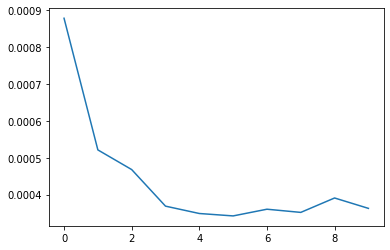

In [ ]:
global_embedding = None # To use at test time

num_minibatch = 512
num_batch = math.floor(len(train_data)/num_minibatch) # Abandoned the leftover
input_dim = 128
hidden_dim = 128
out_dim = 2

RNN_Model = VanillaRNN(input_dim, hidden_dim, out_dim).to(device)
cel = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RNN_Model.parameters(), lr=0.01) 

train_accuracy = []
loss_values = []

for epoch in range(10):
  print('Present Epoch: {}'.format(str(epoch+1) + '/' + str(10)))
  correct = 0
  running_loss = 0

  for batch_idx in range(num_batch): 

      logit, y_train, global_embedding = minibatch_dataloader(train_final_data, num_minibatch, batch_idx, RNN_Model, 'rnn')
      loss = cel(logit, y_train)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      y_pred = logit.argmax(dim=-1)
      correct += (y_pred == y_train).sum().item()

  loss_values.append(running_loss/len(train_data))
  train_accuracy.append(correct / len(train_data))
  print('└Average Loss: {}, Training Accuracy: {}'.format(running_loss / len(train_data), train_accuracy[-1]))

plt.plot(loss_values)

In [ ]:
# dev-set preprocessing

embedding_tensor = torch.zeros([len(dev_data), sentence_maximum_length, input_dim])
length_list = []

with torch.no_grad():
  RNN_Model.eval()
  for i in range(len(dev_data)):
    embedding_list = global_embedding
    one_sentence = dev_data.loc[i, 'sentence'].split(' ')
    length_list.append(len(one_sentence))
    one_sentence.extend(['<Padding>']*(sentence_maximum_length-len(one_sentence)))
    embedding_index = list(map(lambda x: word2id_train[x], one_sentence))
    embedding_input = embedding_list(torch.LongTensor([embedding_index]).to(device))
    embedding_tensor[i] = embedding_input

In [ ]:
RNN_Model.eval()
RNN_dev_accuracy = torch.eq(RNN_Model(embedding_tensor.to(device), max(length_list)).argmax(-1), 
                            torch.LongTensor(dev_label).to(device)).sum().item() / len(dev_data)
print('RNN model dev dataset accuracy: {}'.format(RNN_dev_accuracy))

RNN model dev dataset accuracy: 0.783256880733945


## 4. Text Classification with LSTM and Dropout

Now it is time to improve your baselines! Replace your RNN module with an LSTM module. See Lecture slides 04 and 05 for the formal definition of LSTMs. 

You will also use Dropout, which randomly makes each dimension zero with the probability of `p` and scale it by `1/(1-p)` if it is not zero during training. Put it either at the input or the output of the LSTM to prevent it from overfitting.

In [ ]:
a = torch.FloatTensor([0.1, 0.3, 0.5, 0.7, 0.9])
dropout = nn.Dropout(0.5) # p=0.5
print(dropout(a))

tensor([0.2000, 0.6000, 0.0000, 1.4000, 1.8000])


**Problem 4.1** *(20 points)* Implement and use LSTM (without using PyTorch's LSTM module) instead of vanilla RNN to improve your model. Report the accuracy on the dev data.

---

**Answer** Actually the performance was improved from about 78% to 81%. Highway information from cell state actually induced the performance improvement!

---

**Problem 4.2** *(10 points)* Use Dropout on LSTM (either at input or output). Report the accuracy on the dev data and briefly describe how it differs from 4.

---  

**Answer** The performance of LSTM without dropout was about 81% as stated above. However when I used dropout with remove probability 0.2, the performance was improved to about 84%. Tracking the training accuracy, the accuracy corresponding to each step is larger at the LSTM without dropout. As it is well-known, by using the dropout, I avoided the problem of overfitting a little bit, and I actually got improved result at dev set (Better generalization power)!

---  


**Problem 4.3 (bonus)** *(10 points)* Consider implementing bidirectional LSTM and two layers of LSTM to further improve your model. Report your accuracy on dev data.

**Answer** I was working on Bi-LSTM, and at the training set, I got accuracy over 98 with 10 epochs. 

### Code for Problem 4.1

In [ ]:
class LSTMCell(nn.Module):
  def __init__(self, input_dim, hidden_dim, out_dim=2, dropout=False, dropout_prob=0.5):
    super(LSTMCell, self).__init__()

    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.out_dim = out_dim
    self.dropout = dropout

    ###########################################################
    ##################### The first draft #####################
    ###########################################################

    # self.w_from_x = nn.Linear(self.input_dim, 4*self.layer_dim)
    # self.u_from_h = nn.Linear(self.hidden_dim, 4*self.layer_dim)

    # out_dim: self.hidden_dim for convenience
    self.x_to_f = nn.Linear(self.input_dim, self.hidden_dim)
    self.x_to_i = nn.Linear(self.input_dim, self.hidden_dim)
    self.x_to_o = nn.Linear(self.input_dim, self.hidden_dim)
    self.x_to_c = nn.Linear(self.input_dim, self.hidden_dim)

    self.h_to_f = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.h_to_i = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.h_to_o = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.h_to_c = nn.Linear(self.hidden_dim, self.hidden_dim)

    self.dropout = nn.Dropout(dropout_prob)

    # self.output = nn.Linear(self.hidden_dim, 2)
    
    # if two_layer = True:
    #   self.input_dim_2nd = hidden_dim

    # self.weight_ih = nn.Linear(self.input_dim, 4*self.hidden_dim)
    # self.weight_hh = nn.Linear(self.hidden_dim, 4*self.hidden_dim)
    # self.dropout = nn.Dropout(dropoub_prob)

  # def forward(self, x, previous_hidden, previous_cell, last_layer=False): 
  def forward(self, x, previous_hidden, previous_cell): 

    # internal_calculation = self.w_from_x(x) + self.u_from_h(previous_hidden)
    # forget, input, output, gate = internal_calculation.chunk(4, dim=-1)
    
    if self.dropout==False:
      forget = torch.sigmoid(self.x_to_f(x) + self.h_to_f(previous_hidden))
      input = torch.sigmoid(self.x_to_i(x) + self.h_to_i(previous_hidden))
      output = torch.sigmoid(self.x_to_o(x) + self.h_to_o(previous_hidden))
      gate = torch.tanh(self.x_to_c(x) + self.h_to_c(previous_hidden))

    else:
      forget = torch.sigmoid(self.dropout(self.x_to_f(x)) + self.h_to_f(previous_hidden))
      input = torch.sigmoid(self.dropout(self.x_to_i(x)) + self.h_to_i(previous_hidden))
      output = self.dropout(torch.sigmoid(self.dropout(self.x_to_o(x)) + self.h_to_o(previous_hidden)))
      gate = torch.tanh(self.dropout(self.x_to_c(x)) + self.h_to_c(previous_hidden))     

    next_cell = forget * previous_cell + input * gate
    next_hidden = output * torch.tanh(next_cell)

    
    ################################################################################
    # My first draft: Using only last layer's hidden state for text classification #
    ################################################################################

    # if last_layer == False:
    #   output_cal = None
    # else:
    #   output_cal = self.output(next_hidden)
    #   next_cell = None
    #   next_hidden = None

    # return next_cell, next_hidden, output_cal
   
    return next_cell, next_hidden

In [ ]:
class LSTMwithVariants(nn.Module):
  def __init__(self, input_dim=128, hidden_dim=128, output_dim=2,
               dropout=False, dropout_prob=0.2, bidirectional=None, num_of_layers=None):
    super(LSTMwithVariants, self).__init__()

    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.output = nn.Linear(self.hidden_dim, 2)
    self.dropout = dropout
    self.dropout_prob = dropout_prob

    if glove == True:
      self.embedding = glove_embedding
    else:
      self.embedding = nn.Embedding(len(word_for_2times), self.input_dim, word2id_train['<Padding>']) 
    
    layers = []    
    LSTM_unit = LSTMCell(self.input_dim, self.hidden_dim, self.output_dim, self.dropout, self.dropout_prob)
    layers = [LSTM_unit]*sentence_maximum_length
    self.lstm_extreme = nn.ModuleList(layers)

  def forward(self, x, cutoff):
    self.lstm = self.lstm_extreme[0:cutoff]
    x = x.squeeze()
    
    cell = None
    hidden = None
    hidden_sum = None
    output = None

    for index, layer in enumerate(self.lstm):
      if index == 0:
        cell, hidden = layer(x[:,index,:], torch.zeros(1, self.hidden_dim).to(device), torch.zeros(1, self.hidden_dim).to(device))
        hidden_sum = hidden
      else:
        cell, hidden = layer(x[:,index,:], hidden, cell)
        hidden_sum = torch.add(hidden_sum, hidden)
        if index == cutoff-1:
          output = hidden_sum / cutoff
          output = self.output(output)         

    # for index, layer in enumerate(self.lstm):
    #   if index == 0:
    #     cell, hidden, _ = layer(x[:,index,:], torch.zeros(1, self.hidden_dim).to(device), torch.zeros(1, self.hidden_dim).to(device))
    #   elif index < len(self.lstm)-1:
    #     cell, hidden, _ = layer(x[:,index,:], hidden, cell)
    #   else:
    #     _, _, output = layer(x, hidden, cell, last_layer=True)

    return output

Present Epoch: 1/10
Average Loss: 0.0007884895156901756, Training Accuracy: 0.8014966814652036
Present Epoch: 2/10
Average Loss: 0.0003666600698132556, Training Accuracy: 0.9228644820264592
Present Epoch: 3/10
Average Loss: 0.00024166612034801646, Training Accuracy: 0.9475567565962375
Present Epoch: 4/10
Average Loss: 0.00018132620480066278, Training Accuracy: 0.958128554247279
Present Epoch: 5/10
Average Loss: 0.00013869708696911457, Training Accuracy: 0.9654634812692097
Present Epoch: 6/10
Average Loss: 0.00011588223488159609, Training Accuracy: 0.9703039391824675
Present Epoch: 7/10
Average Loss: 0.00010123410040624164, Training Accuracy: 0.9729320405648191
Present Epoch: 8/10
Average Loss: 9.019875126203861e-05, Training Accuracy: 0.975916494676981
Present Epoch: 9/10
Average Loss: 8.025882937481278e-05, Training Accuracy: 0.9770300969576385
Present Epoch: 10/10
Average Loss: 7.062255067326808e-05, Training Accuracy: 0.9797324384920341


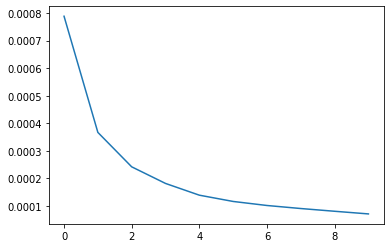

In [ ]:
global_embedding = None # To use at test time

num_minibatch = 512
num_batch = math.floor(len(train_data)/num_minibatch) # Abandoned the leftover

input_dim = 128
hidden_dim = 128
out_dim = 2

LSTM_Model = LSTMwithVariants(input_dim, hidden_dim, out_dim, dropout=False, dropout_prob=0).to(device)
cel = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(LSTM_Model.parameters(), lr=0.01) 

train_accuracy = []
loss_values = []

for epoch in range(10):
  print('Present Epoch: {}'.format(str(epoch+1) + '/' + str(10)))
  correct = 0
  running_loss = 0

  for batch_idx in range(num_batch): 

    logit, y_train, global_embedding = minibatch_dataloader(train_final_data, num_minibatch, batch_idx, LSTM_Model, 'rnn')
    
    loss = cel(logit, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    y_pred = logit.argmax(dim=-1)
    correct += (y_pred == y_train).sum().item()
  
  loss_values.append(running_loss/len(train_data))
  train_accuracy.append(correct / len(train_data))
  print('Average Loss: {}, Training Accuracy: {}'.format(running_loss / len(train_data), train_accuracy[-1]))

plt.plot(loss_values)

In [ ]:
embedding_tensor = torch.zeros([len(dev_data), sentence_maximum_length, input_dim])
length_list = []
LSTM_dev_accuracy = None

with torch.no_grad():
  LSTM_Model.eval()
  for i in range(len(dev_data)):
    embedding_list = global_embedding
    one_sentence = dev_data.loc[i, 'sentence'].split(' ')
    length_list.append(len(one_sentence))
    one_sentence.extend(['<Padding>']*(sentence_maximum_length-len(one_sentence)))
    embedding_index = list(map(lambda x: word2id_train[x], one_sentence))
    embedding_input = embedding_list(torch.LongTensor([embedding_index]).to(device))
    embedding_tensor[i] = embedding_input

    if i == len(dev_data)-1:
      LSTM_dev_accuracy = torch.eq(LSTM_Model(embedding_tensor.to(device), max(length_list)).argmax(-1), 
                                   torch.LongTensor(dev_label).to(device)).sum().item() / len(dev_data)

print('LSTM model dev dataset accuracy: {}'.format(LSTM_dev_accuracy))

LSTM model dev dataset accuracy: 0.805045871559633


### Code for Problem 4.2

Present Epoch: 1/10
Average Loss: 0.0008442797437486115, Training Accuracy: 0.7844956866471663
Present Epoch: 2/10
Average Loss: 0.0003931838227804471, Training Accuracy: 0.9193009547283553
Present Epoch: 3/10
Average Loss: 0.00028527039653922253, Training Accuracy: 0.9408602948818839
Present Epoch: 4/10
Average Loss: 0.00022799368887397643, Training Accuracy: 0.9511648279855677
Present Epoch: 5/10
Average Loss: 0.00019447584394998056, Training Accuracy: 0.9578018975782863
Present Epoch: 6/10
Average Loss: 0.00017643051058543823, Training Accuracy: 0.9610684642682148
Present Epoch: 7/10
Average Loss: 0.00015861165024559526, Training Accuracy: 0.9643350309581434
Present Epoch: 8/10
Average Loss: 0.00014895170998512414, Training Accuracy: 0.9658495300598375
Present Epoch: 9/10
Average Loss: 0.00013856700304448432, Training Accuracy: 0.9667552599147723
Present Epoch: 10/10
Average Loss: 0.00013226773284797045, Training Accuracy: 0.9680024944691087


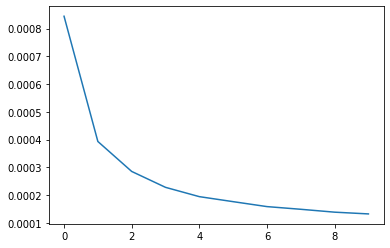

In [ ]:
global_embedding = None # To use at test time

num_minibatch = 512
num_batch = math.floor(len(train_data)/num_minibatch) # Abandoned the leftover

input_dim = 128
hidden_dim = 128
out_dim = 2

LSTM_Model = LSTMwithVariants(input_dim, hidden_dim, out_dim, dropout=True, dropout_prob=0.2).to(device)
cel = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(LSTM_Model.parameters(), lr=0.01) 

train_accuracy = []
loss_values = []

for epoch in range(10):
  print('Present Epoch: {}'.format(str(epoch+1) + '/' + str(10)))
  correct = 0
  running_loss = 0

  for batch_idx in range(num_batch): 

    logit, y_train, global_embedding = minibatch_dataloader(train_final_data, num_minibatch, batch_idx, LSTM_Model,'rnn')
    
    loss = cel(logit, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    y_pred = logit.argmax(dim=-1)
    correct += (y_pred == y_train).sum().item()
  
  loss_values.append(running_loss/len(train_data))
  train_accuracy.append(correct / len(train_data))
  print('Average Loss: {}, Training Accuracy: {}'.format(running_loss / len(train_data), train_accuracy[-1]))

plt.plot(loss_values)

In [ ]:
embedding_tensor = torch.zeros([len(dev_data), sentence_maximum_length, input_dim])
length_list = []
LSTM_dev_accuracy = None

with torch.no_grad():
  LSTM_Model.eval()
  for i in range(len(dev_data)):
    embedding_list = global_embedding
    one_sentence = dev_data.loc[i, 'sentence'].split(' ')
    length_list.append(len(one_sentence))
    one_sentence.extend(['<Padding>']*(sentence_maximum_length-len(one_sentence)))
    embedding_index = list(map(lambda x: word2id_train[x], one_sentence))
    embedding_input = embedding_list(torch.LongTensor([embedding_index]).to(device))
    embedding_tensor[i] = embedding_input

    if i == len(dev_data)-1:
      LSTM_dev_accuracy = torch.eq(LSTM_Model(embedding_tensor.to(device), max(length_list)).argmax(-1), 
                                   torch.LongTensor(dev_label).to(device)).sum().item() / len(dev_data)

print('LSTM model dev dataset accuracy: {}'.format(LSTM_dev_accuracy))

LSTM model dev dataset accuracy: 0.8360091743119266


## 5. Pretrained Word Vectors
The last step is to use pretrained vocabulary and word vectors. The prebuilt vocabulary will replace the vocabulary you built with SST-2 training data, and the word vectors will replace the embedding vectors. You will observe the power of leveraging self-supservised pretrained models.

**Problem 5.1** *(10 points)* Go to https://nlp.stanford.edu/projects/glove/ and download `glove.6B.zip`. Use these pretrained word vectors to further improve your model from 4.2. Report the model's accuracy on the dev data.

---

**Answer**
The accuracy of the model decreased a little bit from about 84% to 81%. However, I think this is because there were a lot of words that glove data could cover to my data. Because of the memory problem, I just used glove.6B.100d.txt including 100 dimensions. Less word, less dimension means less information. For the words that do not exist in the glove data, I just initialized with random normal distribution with mean=0 and variance=1. It is, of course a problem, because these initialization does not include any information about the word itself and the relationship with others. If the data was enough, and if I trained with more data with high-dimension, I am confident that performance would increase, though the amount of increase can be little. 

---

**Problem 5.2 (bonus)** *(10 points)* You can go one step further by using word vectors obtained from pretrained language models. Can you import the word embeddings from `bert-base-uncased` model (via Hugging Face's `transformers`: https://huggingface.co/transformers/pretrained_models.html) into your model and improve it further? Report the accuracy on the dev data here. If the score is now higher, explain where the improvement is coming from.

### Code for Problem 5.1 

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-03-31 13:00:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-31 13:00:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-31 13:00:42--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!pwd

/content/GLUE-baselines


In [ ]:
glove_embedding = torch.randn((len(word_for_2times), 100))

In [ ]:
with open("./glove.6B.100d.txt", 'r') as f:
  while True:
    line = f.readline()
    if not line:
      break
    line_split = line.split(' ')
    word = line_split[0]
    if word in word_for_2times:
      index = word2id_train[word]
      word_embedding = torch.Tensor(list(map(lambda x: float(x), line_split[1:]))).reshape(1, -1)
      glove_embedding[index,:] = word_embedding
  f.close()

In [ ]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer

glove_embedding = create_emb_layer(glove_embedding)

In [ ]:
class LSTMwithVariants(nn.Module):
  def __init__(self, input_dim=128, hidden_dim=128, output_dim=2,
               dropout=False, dropout_prob=0.2, bidirectional=None, num_of_layers=None, glove=True, glove_embedding=glove_embedding):
    super(LSTMwithVariants, self).__init__()

    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.output = nn.Linear(self.hidden_dim, 2)
    self.dropout = dropout
    self.dropout_prob = dropout_prob
    self.embedding = glove_embedding
    
    layers = []    
    LSTM_unit = LSTMCell(self.input_dim, self.hidden_dim, self.output_dim, self.dropout, self.dropout_prob)
    layers = [LSTM_unit]*sentence_maximum_length
    self.lstm_extreme = nn.ModuleList(layers)

  def forward(self, x, cutoff):
    self.lstm = self.lstm_extreme[0:cutoff]
    x = x.squeeze()
    
    cell = None
    hidden = None
    hidden_sum = None
    output = None

    for index, layer in enumerate(self.lstm):
      if index == 0:
        cell, hidden = layer(x[:,index,:], torch.zeros(1, self.hidden_dim).to(device), torch.zeros(1, self.hidden_dim).to(device))
        hidden_sum = hidden
      else:
        cell, hidden = layer(x[:,index,:], hidden, cell)
        hidden_sum = torch.add(hidden_sum, hidden)
        if index == cutoff-1:
          output = hidden_sum / cutoff
          output = self.output(output)         

    # for index, layer in enumerate(self.lstm):
    #   if index == 0:
    #     cell, hidden, _ = layer(x[:,index,:], torch.zeros(1, self.hidden_dim).to(device), torch.zeros(1, self.hidden_dim).to(device))
    #   elif index < len(self.lstm)-1:
    #     cell, hidden, _ = layer(x[:,index,:], hidden, cell)
    #   else:
    #     _, _, output = layer(x, hidden, cell, last_layer=True)

    return output

Present Epoch: 1/10
Average Loss: 0.0008043531298515259, Training Accuracy: 0.7926324073111701
Present Epoch: 2/10
Average Loss: 0.00034570075302382873, Training Accuracy: 0.9286403658554693
Present Epoch: 3/10
Average Loss: 0.0002481490193290341, Training Accuracy: 0.9487149029681213
Present Epoch: 4/10
Average Loss: 0.00019508943763292048, Training Accuracy: 0.9588709557677174
Present Epoch: 5/10
Average Loss: 0.00016633018380675306, Training Accuracy: 0.963978678228333
Present Epoch: 6/10
Average Loss: 0.00014219932177039933, Training Accuracy: 0.9689379203848609
Present Epoch: 7/10
Average Loss: 0.00012612824684557692, Training Accuracy: 0.9710166446420883
Present Epoch: 8/10
Average Loss: 0.00011651394085195803, Training Accuracy: 0.9731844570817682
Present Epoch: 9/10
Average Loss: 0.00010938875265556106, Training Accuracy: 0.9737189861764837
Present Epoch: 10/10
Average Loss: 0.00010133550157578716, Training Accuracy: 0.9757086222512583


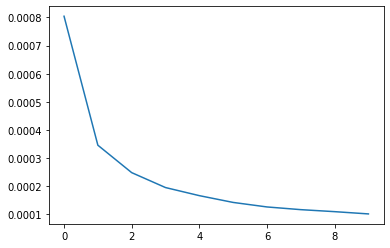

In [ ]:
global_embedding = None
num_minibatch = 512
num_batch = math.floor(len(train_data)/num_minibatch) # Abandoned the leftover

input_dim = 100
hidden_dim = 128
out_dim = 2

LSTM_Model_g = LSTMwithVariants(input_dim, hidden_dim, out_dim, dropout=True, dropout_prob=0.2, 
                                glove=True, glove_embedding=glove_embedding).to(device)
cel = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(LSTM_Model_g.parameters(), lr=0.01) 

train_accuracy = []
loss_values = []

for epoch in range(10):
  print('Present Epoch: {}'.format(str(epoch+1) + '/' + str(10)))
  correct = 0
  running_loss = 0

  for batch_idx in range(num_batch): 

    logit, y_train, global_embedding = minibatch_dataloader(train_final_data, num_minibatch, batch_idx, LSTM_Model_g, 'rnn')
    
    loss = cel(logit, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    y_pred = logit.argmax(dim=-1)
    correct += (y_pred == y_train).sum().item()
  
  loss_values.append(running_loss/len(train_data))
  train_accuracy.append(correct / len(train_data))
  print('Average Loss: {}, Training Accuracy: {}'.format(running_loss / len(train_data), train_accuracy[-1]))

plt.plot(loss_values)

In [ ]:
embedding_tensor = torch.zeros([len(dev_data), sentence_maximum_length, input_dim])
length_list = []
LSTM_dev_accuracy_glove = None

with torch.no_grad():
  LSTM_Model_g.eval()
  for i in range(len(dev_data)):
    embedding_list = global_embedding
    one_sentence = dev_data.loc[i, 'sentence'].split(' ')
    length_list.append(len(one_sentence))
    one_sentence.extend(['<Padding>']*(sentence_maximum_length-len(one_sentence)))
    embedding_index = list(map(lambda x: word2id_train[x], one_sentence))
    embedding_input = embedding_list(torch.LongTensor([embedding_index]).to(device))
    embedding_tensor[i] = embedding_input

    if i == len(dev_data)-1:
      LSTM_dev_accuracy_glove = torch.eq(LSTM_Model_g(embedding_tensor.to(device), max(length_list)).argmax(-1), 
                                         torch.LongTensor(dev_label).to(device)).sum().item() / len(dev_data)

print('LSTM model dev dataset accuracy using the embedding of glove: {}'.format(LSTM_dev_accuracy_glove))

LSTM model dev dataset accuracy using the embedding of glove: 0.8073394495412844
